# Implementación de Grid Search, Pipelines, NLP con corpus de Twitter.

### Intro
Análisis de sentimiento sobre mensajes de twitter mediante la aplicación de técnicas de NLP (Natural Language Processing) y posteriormente ML (Machine Learning). 
Dentro de lo que es el pre-procesamiento de los datos, se limpian y tokenizan para poder generar un BOW (Bag of Words) que permita alimentar los distintos modelos. Cada modelo es entrenado por separado y optimizado mediante la implementación de GridSearch.

#### Preproceso de Datos

In [3]:
import re
import numpy as np
import csv
import unicodedata
import warnings

from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer
#from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold

## Clasificadores
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import MultinomialNB

warnings.filterwarnings('ignore')

# Filenames
file_name="/home/dpedro/union_salida_clasificada_negpos.csv"
stop_file="/home/dpedro/Dropbox/workspace/tfi/tfiEnv/custom_stopwords.txt"    # Nombre del archivo de stopwords.


# Regex para tokenizar correctamente.
regex_str = [
    r'(?:[\w_]+)',                                        # Otras palabras
    r'(?:\S)'                                             # Cualquier otra cosa
]

# Se arman objetos para regular expresions.
tokens_re   = re.compile(r'('+'|'.join(regex_str)+')', re.VERBOSE | re.IGNORECASE)

# Se carga archivos de STOPWORDS
with open(stop_file, newline='') as file:
    stopwords = file.read().splitlines()

resX = []
X = []
y = []
    
# Se abre archivo con tweets y se lo recorre    
with open(file_name, newline='') as csvfile:

    reader = csv.reader(csvfile, delimiter=',', quotechar='\"')
    header = next(reader)
    
    for row in reader:

        y.append(row[0].lower())
        
        tweet = row[1].lower()                    # Se normaliza texto, todo a minusculas.
        tweet = re.sub(r'@[a-z0-9_]+', '', tweet) # Se quitan menciones. @xxxxxxxx
        tweet = re.sub(r'http[s]?://(?:[a-z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-f][0-9a-f]))+', '', tweet)
        tweet = tweet.translate(str.maketrans('','', '.~¡!-_—#$%¿?:+-/°);(/",*“”‘’'))
        
        # Manejo de emoticones.
        emoticones = [
                      ['😆',' risa'],['😂','risa'],['😱',' asombro'],['🥳',' felicidad'],['💙',' amor'],['😍',' amor'],
                      ['😀',' sonreir'],['👍',' ok'],['🤔',' dudar'],['🎊',' alegria'],['🙏',' ojala'],['💪🏻',' fuerza'],
                      ['😡',' enojo'],['😛',' broma'],['😮',' asombro'],['🤮',' desagradable'],['👏🏻',' aplauso'],
                      ['😏',' canchero'],['😩',' decepcion'],['😳',' verguenza'],['😊',' contento'],['😥',' triste'],
                      ['😤',' furioso'],['🖕',' enojo'],['👏',' aplauso'],['💪',' fuerza'],['🤦‍','increible'],
                      ['🙄','duda']
                     ]
        for emoji in emoticones:
            tweet = tweet.replace(emoji[0], emoji[1])

        # Manejo de acentos.
        dict_acentos = [['á','a'],['é','e'],['í','i'],['ó','o'],['ú','u']]
        for acento in dict_acentos:
            tweet = tweet.replace(acento[0], acento[1])
            
        # Remueve letras repetidas y deja una sola.
        for letra in ['a','e','i','o','u','s','c']:
            pattern = letra + '{2,}'
            tweet = re.sub(pattern, letra, tweet)
        
        tweet = tweet.translate(str.maketrans('','', '🥝🐧🐳🖐🛫😑✈🇦🇷🇵🇾👇🙃▶💻►→⬇️😒🔫🔝🔥💀🚫😞♂❤❤❤😎👊🤞🏻'))
        tweet = re.sub(r'\d+', '', tweet)         # Se quitan numeros.
        tweet = tweet.strip()
    
        # Tokenizado
        tokens = tokens_re.findall(tweet)

        # Remocion de stopwords
        tokens = [token for token in tokens if token not in stopwords]
        
        #Para resumen
        resX.append(tokens)
        
        s = ' '
        X.append(s.join(tokens))


### Busqueda de hyperparametros mediante GridSearch

In [5]:
# --- Pipelines ---
pipeline1 = Pipeline([#('vectorizer', CountVectorizer()),
                      ('tfidf', TfidfVectorizer()),
                      ('clf', SVC())
                     ])
pipeline2 = Pipeline([#('vectorizer', CountVectorizer()),
                      #('tfidf', TfidfTransformer()),
                      ('tfidf', TfidfVectorizer()),
                      ('clf', DecisionTreeClassifier())
                     ])
pipeline3 = Pipeline([#('vectorizer', CountVectorizer()),
                      ('tfidf', TfidfVectorizer()),
                      ('clf', MLPClassifier())
                     ])
pipeline4 = Pipeline([#('vectorizer', CountVectorizer()),
                      ('tfidf', TfidfVectorizer()),
                      ('clf', MultinomialNB())
                     ])


# --- Parameters ---
param_svm = [{ 'tfidf__ngram_range': [(1, 1),(1, 2),(2, 2)],
               'tfidf__binary' : (True, False),
               'tfidf__norm': ['l1','l2',None],           #‘l1’, ‘l2’ or None, optional (default=’l2’)
               'tfidf__smooth_idf' : (True, False),
               'tfidf__use_idf': (True, False),
               'clf__kernel': ['rbf','linear'],
               'clf__gamma': [1e-3, 1e-4, 1e-5],
               'clf__C': [1, 10, 100, 1000]
             }]
param_tree = [{ 'tfidf__ngram_range': [(1, 1),(1, 2),(2, 2)],
                'tfidf__binary' : (True, False),
                'tfidf__norm': ['l1','l2',None],           #‘l1’, ‘l2’ or None, optional (default=’l2’)
                'tfidf__smooth_idf' : (True, False),
                'tfidf__use_idf': (True, False),
                'clf__criterion': ['gini', 'entropy'],
                'clf__max_depth': [ 1,2,3,4,5,6,7,8,9,10,11,12,13,14,15],
                'clf__min_samples_leaf': [1, 5, 10, 20]
              }]    
param_red =  [{ 'tfidf__ngram_range': [(1, 1),(1, 2),(2, 2)],
                'tfidf__binary' : (True, False),
                'tfidf__norm': ['l1','l2',None],           #‘l1’, ‘l2’ or None, optional (default=’l2’)
                'tfidf__smooth_idf' : (True, False),
                'tfidf__use_idf': (True, False),
                'clf__solver': ['lbfgs'], 
                'clf__max_iter': [300], 
                'clf__alpha': 10.0 ** -np.arange(1, 7), 
                'clf__hidden_layer_sizes':np.arange(5, 10), 
                'clf__random_state': [6,8] 
              }]
param_nb  =  [{ 'tfidf__ngram_range': [(1, 1),(1, 2),(2, 2)],
                'tfidf__binary' : (True, False),
                'tfidf__norm': ['l1','l2',None],           #‘l1’, ‘l2’ or None, optional (default=’l2’)
                'tfidf__smooth_idf' : (True, False),
                'tfidf__use_idf': (True, False),
                'clf__alpha': np.linspace(0.5, 1.5, 6),
                'clf__fit_prior': [True, False] 
              }]


# --- Scores ---
scores = ['precision', 'recall']
model = [ "SVM", "Neural Network", "Naive Bayes", "Random Forest"]
pips = [pipeline1, pipeline3, pipeline4, pipeline2]
pars = [param_svm, param_red,  param_nb, param_tree]


# --- Cros Validate ---
cvNum = 10
print("Comenzando Gridsearch!")

for i in range(len(pars)):
    print(model[i])
    for score in scores:
        
        gs_clf = GridSearchCV( pips[i], pars[i], cv=cvNum, 
                                   scoring='%s_weighted' % score, n_jobs=-1, 
                                   verbose=0, refit=False)
        gs_clf = gs_clf.fit(X, y)
        print(score, gs_clf.best_score_)
        print("Parametros: %s" % gs_clf.best_params_)

Comenzando Gridsearch!
SVM
precision 0.8409689563244563
Parametros: {'clf__C': 10, 'clf__gamma': 0.001, 'clf__kernel': 'rbf', 'tfidf__binary': True, 'tfidf__ngram_range': (1, 1), 'tfidf__norm': None, 'tfidf__smooth_idf': True, 'tfidf__use_idf': True}
recall 0.8368421052631579
Parametros: {'clf__C': 10, 'clf__gamma': 0.001, 'clf__kernel': 'rbf', 'tfidf__binary': True, 'tfidf__ngram_range': (1, 1), 'tfidf__norm': None, 'tfidf__smooth_idf': True, 'tfidf__use_idf': True}
Neural Network
precision 0.8610996190265553
Parametros: {'clf__alpha': 0.001, 'clf__hidden_layer_sizes': 8, 'clf__max_iter': 300, 'clf__random_state': 6, 'clf__solver': 'lbfgs', 'tfidf__binary': True, 'tfidf__ngram_range': (1, 1), 'tfidf__norm': None, 'tfidf__smooth_idf': True, 'tfidf__use_idf': True}
recall 0.8552631578947368
Parametros: {'clf__alpha': 0.001, 'clf__hidden_layer_sizes': 8, 'clf__max_iter': 300, 'clf__random_state': 6, 'clf__solver': 'lbfgs', 'tfidf__binary': True, 'tfidf__ngram_range': (1, 1), 'tfidf__norm

### GridSearch con Mejores Parametros

In [170]:
# --- Pipelines ---
pipeline1 = Pipeline([('tfidf', TfidfVectorizer()), ('clf', SVC()) ])
pipeline2 = Pipeline([('tfidf', TfidfVectorizer()), ('clf', DecisionTreeClassifier())])
pipeline3 = Pipeline([('tfidf', TfidfVectorizer()), ('clf', MLPClassifier())])
pipeline4 = Pipeline([('tfidf', TfidfVectorizer()), ('clf', MultinomialNB())])

# --- Parameters ---
param_svm = [{ 'tfidf__ngram_range': [(1, 1)], 'tfidf__binary': [True],
               'tfidf__norm': [None],           #‘l1’, ‘l2’ or None, optional (default=’l2’)
               'tfidf__smooth_idf' : [True], 'tfidf__use_idf': [True],
               'clf__kernel': ['rbf'], 'clf__gamma': [0.001], 'clf__C': [10]
             }]

param_tree = [{ 'tfidf__ngram_range': [(1, 1)], 'tfidf__binary' : [False],
                'tfidf__norm': ['l1'],           #‘l1’, ‘l2’ or None, optional (default=’l2’)
                'tfidf__smooth_idf' : [False], 'tfidf__use_idf': [True],
                'clf__criterion': ['gini'], 'clf__max_depth': [ 4 ], 'clf__min_samples_leaf': [ 10 ]
              }]

param_red =  [{ 'tfidf__ngram_range': [(1, 1)], 'tfidf__binary' : [True],
                'tfidf__norm': [None],           #‘l1’, ‘l2’ or None, optional (default=’l2’)
                'tfidf__smooth_idf' : [True], 'tfidf__use_idf': [True],
                'clf__solver': ['lbfgs'], 'clf__max_iter': [300], 'clf__alpha': [0.001], 'clf__hidden_layer_sizes': [8]
              }]

param_nb  =  [{ 'tfidf__ngram_range': [(1, 2)], 'tfidf__binary' : [False],
                'tfidf__norm': [None],           #‘l1’, ‘l2’ or None, optional (default=’l2’)
                'tfidf__smooth_idf' : [True], 'tfidf__use_idf': [False],
                'clf__alpha': [0.9], 'clf__fit_prior': [False] 
              }]

# --- Scores ---
scores = ['precision', 'recall']
model = [ "SVM", "Neural Network", "Naive Bayes", "Random Forest"]
pips = [pipeline1, pipeline3, pipeline4, pipeline2]
pars = [param_svm, param_red,  param_nb, param_tree]


# --- Cros Validate ---
cvNum = 10
print("Comenzando Gridsearch!\n")

for i in range(len(pars)):
    print(model[i])
    for score in scores:
        
        gs_clf = GridSearchCV( pips[i], pars[i], cv=cvNum, 
                                   scoring='%s_weighted' % score, n_jobs=-1, 
                                   verbose=0, refit=False)
        gs_clf = gs_clf.fit(X, y)
        print(score, '%.2f' % gs_clf.best_score_)
    print("Parametros: %s\n" % gs_clf.best_params_)


Comenzando Gridsearch!

SVM
precision 0.84
recall 0.84
Parametros: {'clf__C': 10, 'clf__gamma': 0.001, 'clf__kernel': 'rbf', 'tfidf__binary': True, 'tfidf__ngram_range': (1, 1), 'tfidf__norm': None, 'tfidf__smooth_idf': True, 'tfidf__use_idf': True}

Neural Network
precision 0.84
recall 0.82
Parametros: {'clf__alpha': 0.001, 'clf__hidden_layer_sizes': 8, 'clf__max_iter': 300, 'clf__solver': 'lbfgs', 'tfidf__binary': True, 'tfidf__ngram_range': (1, 1), 'tfidf__norm': None, 'tfidf__smooth_idf': True, 'tfidf__use_idf': True}

Naive Bayes
precision 0.86
recall 0.85
Parametros: {'clf__alpha': 0.9, 'clf__fit_prior': False, 'tfidf__binary': False, 'tfidf__ngram_range': (1, 2), 'tfidf__norm': None, 'tfidf__smooth_idf': True, 'tfidf__use_idf': False}

Random Forest
precision 0.78
recall 0.74
Parametros: {'clf__criterion': 'gini', 'clf__max_depth': 4, 'clf__min_samples_leaf': 10, 'tfidf__binary': False, 'tfidf__ngram_range': (1, 1), 'tfidf__norm': 'l1', 'tfidf__smooth_idf': False, 'tfidf__use_id

In [197]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_validate
from sklearn.metrics import recall_score

np.set_printoptions(precision=3) # Precision de numpy

def plot_confusion_matrix(y_true, y_pred, classes, normalize=False, title='Matriz de confusión', cmap=plt.cm.Blues):

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = ["POS","NEG"]
    
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Matriz de confusión')

    #print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='ACTUAL',
           xlabel='PREDICTED')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

## Aplicación de clasificadores sin GridSearch.
Luego de aplicar gridsearch con el mejor set de hyperparametros para cada clasificador y para cada generador de modelo de datos, surgió el inconveniente de no poder utilizar mas que el ultimo que se había probado. Es por esto que se implementa debajo, cada clasificador por separado. 

### Resultados sobre SVM

Precision: 0.86 (+/- 0.06)
Recall:    0.70 (+/- 0.05)
Matriz de confusión


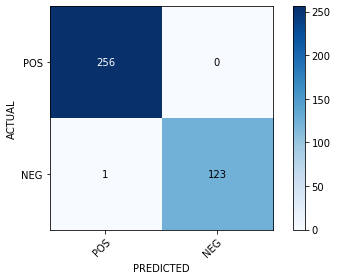

In [201]:
# Armo BOW
vectorizer = TfidfVectorizer(binary=True, ngram_range=(1, 1), norm= 'l2', smooth_idf= False, use_idf= True)
Xnum = vectorizer.fit_transform(X)

# Seteamos clasificador
clf = SVC(kernel='linear', C=1, gamma=0.001)

scoring = ['precision_macro', 'recall_macro']
scores = cross_validate(clf, Xnum, y, scoring=scoring, cv=10)

print("Precision: %0.2f (+/- %0.2f)" % (scores['test_precision_macro'].mean(), scores['test_precision_macro'].std()))
print("Recall:    %0.2f (+/- %0.2f)" % (scores['test_recall_macro'].mean(), scores['test_recall_macro'].std()))

# Imprimir matriz de confusion.
clf = clf.fit(Xnum, y)
y_pred_dt = clf.predict(Xnum)
plot_confusion_matrix(y, y_pred_dt, classes=class_names, title='')
plt.show()

### Resultados sobre Red Neuronal

Precision: 0.84 (+/- 0.05)
Recall:    0.81 (+/- 0.05)
Matriz de confusión


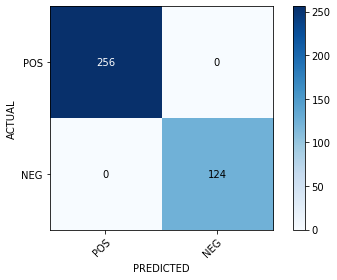

In [200]:
# Armo BOW
vectorizer = TfidfVectorizer(binary=True, ngram_range=(1, 1), norm= None, smooth_idf= False, use_idf= True)
Xnum = vectorizer.fit_transform(X)

# Seteamos clasificador
clf = MLPClassifier(alpha= 0.0001, hidden_layer_sizes= 8, max_iter= 300, solver= 'lbfgs')
#random_state= 6

scoring = ['precision_macro', 'recall_macro']
scores = cross_validate(clf, Xnum, y, scoring=scoring, cv=10)

print("Precision: %0.2f (+/- %0.2f)" % (scores['test_precision_macro'].mean(), scores['test_precision_macro'].std()))
print("Recall:    %0.2f (+/- %0.2f)" % (scores['test_recall_macro'].mean(), scores['test_recall_macro'].std()))

# Imprimir matriz de confusion.
clf = clf.fit(Xnum, y)
y_pred_dt = clf.predict(Xnum)
plot_confusion_matrix(y, y_pred_dt, classes=class_names, title='')
plt.show()

### Resultados sobre Naive Bayes

Precision: 0.71 (+/- 0.08)
Recall:    0.72 (+/- 0.09)
Matriz de confusión


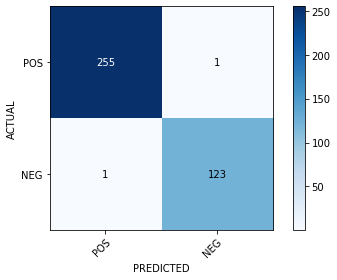

In [199]:
# Armo BOW
vectorizer = TfidfVectorizer(binary=False, ngram_range=(1, 2), norm= None, smooth_idf= True, use_idf= False)
Xnum = vectorizer.fit_transform(X)

# Seteamos clasificador
clf = MultinomialNB(alpha= 0.9, fit_prior= False)
#random_state= 6

from sklearn.model_selection import cross_validate
from sklearn.metrics import recall_score

scoring = ['precision_macro', 'recall_macro']
scores = cross_validate(clf, Xnum, y, scoring=scoring, cv=10, n_jobs=-1)
#print(scores['test_precision_macro'])
print("Precision: %0.2f (+/- %0.2f)" % (scores['test_precision_macro'].mean(), scores['test_precision_macro'].std()))
print("Recall:    %0.2f (+/- %0.2f)" % (scores['test_recall_macro'].mean(), scores['test_recall_macro'].std()))

# Imprimir matriz de confusion.
clf = clf.fit(Xnum, y)
y_pred_dt = clf.predict(Xnum)
plot_confusion_matrix(y, y_pred_dt, classes=class_names, title='')
plt.show()

### Resultados sobre Arbol de Decision

Precision: 0.73 (+/- 0.08)
Recall:    0.65 (+/- 0.06)
Matriz de confusión


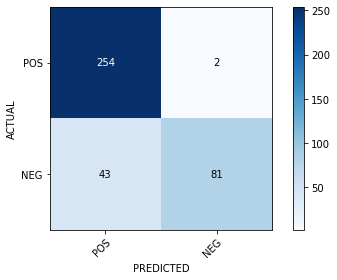

In [198]:
# Armo BOW
vectorizer = TfidfVectorizer(binary= True, ngram_range=(1, 1), norm= None, smooth_idf= False, use_idf= False)
Xnum = vectorizer.fit_transform(X)

# Seteamos clasificador
clf = DecisionTreeClassifier(criterion= 'entropy', max_depth= 14, min_samples_leaf= 1)

scoring = ['precision_macro', 'recall_macro']
scores = cross_validate(clf, Xnum, y, scoring=scoring, cv=10, n_jobs=-1)

print("Precision: %0.2f (+/- %0.2f)" % (scores['test_precision_macro'].mean(), scores['test_precision_macro'].std()))
print("Recall:    %0.2f (+/- %0.2f)" % (scores['test_recall_macro'].mean(), scores['test_recall_macro'].std()))

# Imprimir matriz de confusion.
clf = clf.fit(Xnum, y)
y_pred_dt = clf.predict(Xnum)
plot_confusion_matrix(y, y_pred_dt, classes=class_names, title='')
plt.show()